
# Diksha Prasad; Matriculation : 7891818
# AudioMNIST — Digit & Speaker Classification with CNNs and LSTMs (CRNN)

**Dataset:** [AudioMNIST (GitHub)](https://github.com/soerenab/AudioMNIST)

In this notebook I am using **state-of-the-art style baselines** for both tasks on the AudioMNIST dataset:

1. **Digit classification** (0–9)
2. **Speaker identification** (60 speakers)

I am focusing on deep-learning approaches : **CNNs** on log-mel spectrograms and a **CRNN (CNN + BiLSTM + Attention)** sequence model. These are the workhorses for short-utterance audio classification and typically reach very high accuracies (often ~99%+ on AudioMNIST when trained properly).

> What I did in the notebook:
> - Downloaded/prepared the dataset automatically (from GitHub).
> - Built spectrogram pipelines (log-mel / MFCC).
> - Implemented strong data augmentations (SpecAugment-style time/frequency masking, random time shift, noise).
> - Included two well-tuned models:
>   - **CNN-Strong** for digits.
>   - **CRNN-XL (CNN → BiLSTM → Attention)** for speakers.
> - Used **mixed precision**, **cosine LR schedule**, **early stopping**, and **gradient clipping**.
> - Produced **confusion matrices** and per-class metrics.
> - Saved the best checkpoints and provided a simple **inference** function.

---

## How to use

- Choose the **task** in the **Configuration** cell by setting `task = "digit"` or `task = "speaker"`.  
- For *digit classification*, the data is split **by speakers** (speaker-independent evaluation).  
- For *speaker identification*, the data is split **by utterances** within each speaker.

### About the Two Code Variants

I included **two separate code cells** for clarity:
- One dedicated to **digit classification** using the **CNNStrong** model.
- Another for **speaker identification** using the **CRNN-XL** model.

This makes it easier to display the results, inference examples, and performance metrics for each task **independently**.

However, both tasks can also be handled with a **single training cell** by simply changing  
`CFG.task = "digit"` → `CFG.task = "speaker"` before running it.

In the **comparison showcase**, I trained and evaluated each task separately,  
then presented their results, inference outputs, and accuracy side by side.



## 1) Environment & installs



In [1]:
import os, re, json, math, random, time, shutil, sys, subprocess, zipfile, itertools
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm import tqdm

import librosa, librosa.display
import soundfile as sf

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available(), "| Device:", DEVICE)


Torch: 2.8.0+cu126 | CUDA: True | Device: cuda



## 2) Configuration

Choose the **task** and hyperparameters here. Defaults are strong and should converge quickly to very high accuracy.


In [2]:

@dataclass
class Config:
    # choose: "digit" or "speaker"
    task: str = "digit"

    # audio & features
    target_sr: int = 16000
    n_fft: int = 1024
    hop_length: int = 256
    n_mels: int = 64
    fmin: int = 20
    fmax: int = 7600
    max_duration: float = 1.2   # seconds (pad/trim)
    top_db_trim: int = 40       # for trim

    # augmentation
    time_shift_pct: float = 0.1
    add_noise_snr_db: float = 30.0  # higher = less noise, set None to disable
    freq_mask_param: int = 8    # SpecAugment (frequency)
    time_mask_param: int = 16   # SpecAugment (time)
    augment_prob: float = 0.8

    # training
    batch_size: int = 64
    lr: float = 3e-4
    weight_decay: float = 1e-4
    epochs: int = 30
    warmup_epochs: int = 2
    num_workers: int = 2
    mixed_precision: bool = True
    grad_clip: float = 5.0
    early_stop_patience: int = 6

    # model sizes
    cnn_channels: tuple = (32, 64, 128, 256)
    lstm_hidden: int = 192
    lstm_layers: int = 2
    lstm_dropout: float = 0.2

    # splits
    val_speakers: int = 10  # for digit task: number of speakers held out for val+test
    test_speakers: int = 10
    seed: int = 1337

CFG = Config()
print(CFG)


Config(task='digit', target_sr=16000, n_fft=1024, hop_length=256, n_mels=64, fmin=20, fmax=7600, max_duration=1.2, top_db_trim=40, time_shift_pct=0.1, add_noise_snr_db=30.0, freq_mask_param=8, time_mask_param=16, augment_prob=0.8, batch_size=64, lr=0.0003, weight_decay=0.0001, epochs=30, warmup_epochs=2, num_workers=2, mixed_precision=True, grad_clip=5.0, early_stop_patience=6, cnn_channels=(32, 64, 128, 256), lstm_hidden=192, lstm_layers=2, lstm_dropout=0.2, val_speakers=10, test_speakers=10, seed=1337)



## 3) Reproducibility helpers


In [3]:

def set_seed(seed=1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG.seed)



## 4) Download & index the dataset

I cloned the original repo (≈1.9GB with audio). Filenames follow the pattern:  
`{digit}_{speakerID}_{utteranceIndex}.wav` (e.g., `7_004_12.wav`).

The audio lives nested in subfolders; I'll **glob** `**/*.wav` and parse digit + speaker from names.


In [4]:

DATA_ROOT = Path("./AudioMNIST_data")
REPO_URL = "https://github.com/soerenab/AudioMNIST.git"
REPO_DIR = DATA_ROOT / "AudioMNIST"

if not REPO_DIR.exists():
    REPO_DIR.parent.mkdir(parents=True, exist_ok=True)
    print("Cloning AudioMNIST...")
    subprocess.run(["git", "clone", "--depth", "1", REPO_URL, str(REPO_DIR)], check=False)
else:
    print("Repo exists. Skipping clone.")

# Try to locate WAVs
wav_paths = list(REPO_DIR.rglob("*.wav"))
print(f"Found WAV files: {len(wav_paths)}")

# Regex matches e.g. '3_042_17.wav'
name_re = re.compile(r'(?P<digit>\d+)_(?P<speaker>\d+)_(?P<idx>\d+)\.wav$')

rows = []
for p in wav_paths:
    m = name_re.search(p.name)
    if not m:
        continue
    rows.append({
        "path": str(p),
        "digit": int(m.group("digit")),
        "speaker": int(m.group("speaker")),
        "idx": int(m.group("idx"))
    })

meta = pd.DataFrame(rows).sort_values(["speaker", "digit", "idx"]).reset_index(drop=True)
print(meta.head(), "\nTotal parsed:", len(meta))



Cloning AudioMNIST...
Found WAV files: 30000
                                            path  digit  speaker  idx
0  AudioMNIST_data/AudioMNIST/data/01/0_01_0.wav      0        1    0
1  AudioMNIST_data/AudioMNIST/data/01/0_01_1.wav      0        1    1
2  AudioMNIST_data/AudioMNIST/data/01/0_01_2.wav      0        1    2
3  AudioMNIST_data/AudioMNIST/data/01/0_01_3.wav      0        1    3
4  AudioMNIST_data/AudioMNIST/data/01/0_01_4.wav      0        1    4 
Total parsed: 30000



## 5) Train/Val/Test splits

- **Digit task:** we create **speaker-independent** splits: choose `val_speakers` and `test_speakers` distinct from the training speakers.
- **Speaker task:** we split **by utterances** within each speaker (stratified by speaker).


In [5]:

def make_splits(meta: pd.DataFrame, task: str):
    rng = np.random.default_rng(CFG.seed)
    if task == "digit":
        speakers = sorted(meta["speaker"].unique())
        rng.shuffle(speakers)
        val_spk = set(speakers[:CFG.val_speakers])
        test_spk = set(speakers[CFG.val_speakers:CFG.val_speakers+CFG.test_speakers])
        train_spk = set(speakers[CFG.val_speakers+CFG.test_speakers:])

        trn = meta[meta.speaker.isin(train_spk)].copy()
        val = meta[meta.speaker.isin(val_spk)].copy()
        tst = meta[meta.speaker.isin(test_spk)].copy()

        y_cols = ["digit"]
        n_classes = 10
    else:  # speaker identification
        # split by utterances per speaker: 70/15/15 stratified by speaker
        parts = []
        for spk, df_spk in meta.groupby("speaker"):
            idxs = df_spk.index.to_numpy()
            rng.shuffle(idxs)
            n = len(idxs)
            n_tr = int(0.7*n); n_va = int(0.15*n)
            tr = df_spk.loc[idxs[:n_tr]]
            va = df_spk.loc[idxs[n_tr:n_tr+n_va]]
            te = df_spk.loc[idxs[n_tr+n_va:]]
            parts.append(("train", tr)); parts.append(("val", va)); parts.append(("test", te))
        trn = pd.concat([x for tag, x in parts if tag=="train"]).sort_index()
        val = pd.concat([x for tag, x in parts if tag=="val"]).sort_index()
        tst = pd.concat([x for tag, x in parts if tag=="test"]).sort_index()

        y_cols = ["speaker"]
        n_classes = meta["speaker"].nunique()

    print(f"[{task}] Train {len(trn)} | Val {len(val)} | Test {len(tst)} | Classes {n_classes}")
    return trn, val, tst, y_cols[0], n_classes

train_df, val_df, test_df, target_col, n_classes = make_splits(meta, CFG.task)


[digit] Train 20000 | Val 5000 | Test 5000 | Classes 10



## 6) Audio I/O, feature extraction & augmentations
Here, I compute **log-mel spectrograms** and additionally provide **frame-wise features** for the LSTM. Augmentations are applied on the spectrograms.


In [10]:

def load_audio(path, target_sr=16000, max_duration=1.2, top_db=40):
    x, sr = sf.read(path, dtype="float32")
    if x.ndim > 1:
        x = np.mean(x, axis=1)
    # Trim leading/trailing silence
    x, _ = librosa.effects.trim(x, top_db=top_db)
    # Resample if needed
    if sr != target_sr:
        x = librosa.resample(y=x, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    # Pad/trim to fixed length
    max_len = int(max_duration * sr)
    if len(x) > max_len:
        x = x[:max_len]
    else:
        x = np.pad(x, (0, max_len - len(x)))
    return x, sr

def to_logmelspec(x, sr, n_fft, hop_length, n_mels, fmin, fmax):
    S = librosa.feature.melspectrogram(
        y=x, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmin=fmin, fmax=fmax, power=2.0
    )
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db  # shape: (n_mels, T)

def random_time_shift(mel, max_pct=0.1):
    # shift along time axis
    T = mel.shape[1]
    max_shift = int(T * max_pct)
    if max_shift <= 0:
        return mel
    shift = np.random.randint(-max_shift, max_shift+1)
    return np.roll(mel, shift, axis=1)

def add_noise_waveform(x, snr_db=30.0):
    if snr_db is None:
        return x
    # signal power and noise power
    sig_pow = np.mean(x**2) + 1e-9
    snr = 10**(snr_db/10)
    noise_pow = sig_pow / snr
    noise = np.random.normal(scale=np.sqrt(noise_pow), size=x.shape).astype(np.float32)
    return x + noise

def spec_augment(mel, freq_mask_param=8, time_mask_param=16):
    mel = mel.copy()
    # Frequency mask
    f = mel.shape[0]
    for _ in range(1):
        f0 = np.random.randint(0, max(1, f - freq_mask_param))
        width = np.random.randint(0, freq_mask_param+1)
        mel[f0:f0+width, :] = mel.min()
    # Time mask
    t = mel.shape[1]
    for _ in range(1):
        t0 = np.random.randint(0, max(1, t - time_mask_param))
        width = np.random.randint(0, time_mask_param+1)
        mel[:, t0:t0+width] = mel.min()
    return mel

class AudioMNISTDataset(Dataset):
    def __init__(self, df, target_col, training=True):
        self.df = df.reset_index(drop=True)
        self.target_col = target_col
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x, sr = load_audio(row.path, CFG.target_sr, CFG.max_duration, CFG.top_db_trim)
        if self.training and random.random() < CFG.augment_prob:
            x = add_noise_waveform(x, CFG.add_noise_snr_db)
        mel = to_logmelspec(x, sr, CFG.n_fft, CFG.hop_length, CFG.n_mels, CFG.fmin, CFG.fmax)
        if self.training and random.random() < CFG.augment_prob:
            mel = random_time_shift(mel, CFG.time_shift_pct)
            mel = spec_augment(mel, CFG.freq_mask_param, CFG.time_mask_param)


        mean = np.mean(mel); std = np.std(mel) + 1e-9
        mel = (mel - mean) / std


        mel_tensor = torch.tensor(mel, dtype=torch.float32)
        x_cnn = mel_tensor.unsqueeze(0)
        x_seq = mel_tensor.transpose(0,1)

        y = int(row[self.target_col])
        return x_cnn, x_seq, y

def make_loaders(train_df, val_df, test_df):
    tr_ds = AudioMNISTDataset(train_df, target_col, training=True)
    va_ds = AudioMNISTDataset(val_df,   target_col, training=False)
    te_ds = AudioMNISTDataset(test_df,  target_col, training=False)

    tr_dl = DataLoader(tr_ds, batch_size=CFG.batch_size, shuffle=True,  num_workers=CFG.num_workers, pin_memory=True)
    va_dl = DataLoader(va_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
    te_dl = DataLoader(te_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
    return tr_dl, va_dl, te_dl

train_loader, val_loader, test_loader = make_loaders(train_df, val_df, test_df)



## 7) Models

I provide two high-performing architectures:

- **CNN-Strong** (for digits): 4 conv blocks + global pooling + dropout + classifier.
- **CRNN-XL** (for speakers): 2 conv blocks → **BiLSTM** → **attention pooling** → classifier.

> You can use either model for either task, but these defaults are strong starting points.


## Understanding the Two Approaches: Digit Classification vs. Speaker Identification

Although both use the same preprocessing pipeline (audio trimming, resampling, log-mel spectrogram extraction, and normalization), the learning goals and model designs differ substantially.

---

### 1. Digit Classification (CNNStrong Model)

**Objective:**  
Identify which digit (0–9) is spoken, regardless of who the speaker is.

**Key Idea:**  
Spoken digits have consistent and distinctive **spectro-temporal patterns** (energy distribution over frequency and time).  
A convolutional neural network (CNN) can effectively capture these local frequency-time structures similar to how CNNs recognize shapes in images.

**Model Architecture — `CNNStrong`:**
- **Input:** Log-mel spectrogram (1 × 64 × T) treated as a 2D “image”.
- **Four convolutional blocks**:
  - Each block: `Conv2D → BatchNorm → ReLU → Conv2D → BatchNorm → ReLU → MaxPool`
  - Extracts hierarchical frequency-time features, gradually reducing resolution.
- **Global Average Pooling:** Compresses spatial features into a single embedding vector.
- **Fully Connected Head:**  
  - `Linear(256) → ReLU → Dropout → Linear(10)`  
  - Outputs class probabilities for the 10 digits.
- **Loss Function:** Cross-entropy between predicted and true digit labels.
- **Why CNN works best here:**  
  Digits have strong, localized patterns in the spectrogram; CNN filters capture these invariant features robustly across different speakers.


---

### 2. Speaker Identification (CRNN-XL Model)

**Objective:**  
Recognize **who** is speaking (among 60 speakers), regardless of which digit was spoken.

**Key Idea:**  
Unlike digits, speaker identity depends on **temporal dynamics** and **spectral characteristics** such as pitch, timbre, and articulation — which evolve over time.  
This requires both local feature extraction and temporal sequence modeling.

**Model Architecture — `CRNN-XL`:**
- **Input:** Log-mel spectrogram (1 × 64 × T).
- **CNN Front-end (Feature Extractor):**
  - Two light convolutional layers (`Conv2D + BatchNorm + ReLU + MaxPool`).
  - Compresses frequency axis and filters out local noise.
- **Bi-LSTM (Temporal Encoder):**
  - Bidirectional LSTM layers model temporal dependencies and speaker-specific vocal patterns.
  - Each frame’s feature depends on both past and future context.
- **Attention Pooling:**
  - Learns to **weigh frames** differently — focusing more on those carrying distinctive speaker traits.
  - Produces a single speaker embedding per utterance.
- **Fully Connected Classifier:**
  - `Linear(256) → ReLU → Dropout → Linear(60)` for 60 speakers.
- **Loss Function:** Cross-entropy over speaker classes.
- **Why CRNN works best here:**  
  Speaker identity requires understanding **how** speech is produced over time; the LSTM captures this sequence information while CNN and attention handle feature extraction and aggregation.

---

Both models leverage **log-mel spectrograms** but differ in how they interpret time-frequency information.  
CNNStrong excels at identifying **phonetic patterns**, while CRNN-XL learns **temporal and stylistic patterns** tied to the speaker’s voice.

---



In [11]:

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, p=1, pool=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=k, padding=p),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(kernel_size=pool)
    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x

class CNNStrong(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        chs = CFG.cnn_channels
        self.backbone = nn.Sequential(
            ConvBlock(1, chs[0]),
            ConvBlock(chs[0], chs[1]),
            ConvBlock(chs[1], chs[2]),
            ConvBlock(chs[2], chs[3]),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(chs[3], 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )
    def forward(self, x_cnn, x_seq=None):
        x = self.backbone(x_cnn)
        return self.head(x)

class AttentionPool(nn.Module):
    def __init__(self, dim, attn_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim, attn_dim),
            nn.Tanh(),
            nn.Linear(attn_dim, 1)
        )
    def forward(self, x):
        scores = self.fc(x).squeeze(-1)
        w = torch.softmax(scores, dim=1).unsqueeze(-1)
        pooled = (x * w).sum(dim=1)
        return pooled, w

class CRNN_XL(nn.Module):
    def __init__(self, n_classes, lstm_hidden=192, lstm_layers=2, lstm_dropout=0.2):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d((2,1)),
        )
        self.lstm = nn.LSTM(
            input_size=(CFG.n_mels//4)*64,
            hidden_size=CFG.lstm_hidden,
            num_layers=CFG.lstm_layers,
            dropout=lstm_dropout if CFG.lstm_layers>1 else 0.0,
            bidirectional=True,
            batch_first=True
        )
        self.attn = AttentionPool(dim=CFG.lstm_hidden*2, attn_dim=128)
        self.head = nn.Sequential(
            nn.Linear(CFG.lstm_hidden*2, 256),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )
    def forward(self, x_cnn, x_seq=None):
        z = self.cnn(x_cnn)
        B, C, Fp, Tp = z.shape
        z = z.permute(0, 3, 1, 2).contiguous()
        z = z.view(B, Tp, C*Fp)
        out, _ = self.lstm(z)
        pooled, _ = self.attn(out)
        logits = self.head(pooled)
        return logits



## 8) Training loop (mixed precision, early stopping, cosine LR)


In [13]:

class AverageMeter:
    def __init__(self):
        self.reset()
    def reset(self):
        self.sum = 0.0; self.cnt = 0
    def update(self, val, n=1):
        self.sum += val*n; self.cnt += n
    @property
    def avg(self):
        return self.sum / max(1, self.cnt)

def train_one_epoch(model, loader, criterion, optimizer, scaler=None):
    model.train()
    loss_m = AverageMeter()
    acc_m = AverageMeter()
    for x_cnn, x_seq, y in loader:
        x_cnn, y = x_cnn.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):
            logits = model(x_cnn, x_seq)
            loss = criterion(logits, y)
        if scaler is not None:
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.grad_clip)
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.grad_clip)
            optimizer.step()
        preds = logits.argmax(1)
        acc = (preds == y).float().mean().item()
        loss_m.update(loss.item(), n=y.size(0))
        acc_m.update(acc, n=y.size(0))
    return loss_m.avg, acc_m.avg

@torch.no_grad()
def eval_model(model, loader, criterion):
    model.eval()
    loss_m = AverageMeter()
    all_y, all_p = [], []
    for x_cnn, x_seq, y in loader:
        x_cnn, y = x_cnn.to(DEVICE), y.to(DEVICE)
        logits = model(x_cnn, x_seq)
        loss = criterion(logits, y)
        loss_m.update(loss.item(), n=y.size(0))
        all_y.append(y.cpu().numpy())
        all_p.append(logits.softmax(1).cpu().numpy())
    y_true = np.concatenate(all_y)
    prob = np.concatenate(all_p)
    y_pred = prob.argmax(1)
    acc = accuracy_score(y_true, y_pred)
    return loss_m.avg, acc, y_true, y_pred, prob

def run_training(model, train_loader, val_loader, n_classes, run_name="model"):
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=max(1, CFG.epochs - CFG.warmup_epochs))
    scaler = torch.amp.GradScaler('cuda', enabled=(CFG.mixed_precision and DEVICE.type=="cuda"))

    best_val = -1.0
    patience = CFG.early_stop_patience
    best_path = Path(f"./{run_name}_best.pt")

    for epoch in range(1, CFG.epochs+1):
        t0 = time.time()
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler)
        va_loss, va_acc, _, _, _ = eval_model(model, val_loader, criterion)
        if epoch > CFG.warmup_epochs:
            scheduler.step()
        dt = time.time() - t0
        print(f"Epoch {epoch:02d} | {dt:.1f}s | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
        if va_acc > best_val:
            best_val = va_acc
            patience = CFG.early_stop_patience
            torch.save({"model": model.state_dict(), "cfg": CFG.__dict__, "n_classes": n_classes}, best_path)
        else:
            patience -= 1
            if patience <= 0:
                print("Early stopping.")
                break
    print("Best val acc:", best_val, "| saved to", best_path)
    return best_path



## 9) Train

By default:
- **Digit task → CNNStrong**
- **Speaker task → CRNN_XL**


In [14]:

if CFG.task == "digit":
    model = CNNStrong(n_classes)
    run_name = "digits_cnnstrong"
else:
    model = CRNN_XL(n_classes, lstm_hidden=CFG.lstm_hidden, lstm_layers=CFG.lstm_layers, lstm_dropout=CFG.lstm_dropout)
    run_name = "speakers_crnnxl"

best_ckpt = run_training(model, train_loader, val_loader, n_classes, run_name=run_name)


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 01 | 233.8s | train loss 0.6100 acc 0.8226 | val loss 0.5734 acc 0.8076


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 02 | 224.4s | train loss 0.0971 acc 0.9713 | val loss 0.1383 acc 0.9534


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 03 | 225.5s | train loss 0.0589 acc 0.9830 | val loss 0.0459 acc 0.9872


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 04 | 218.7s | train loss 0.0487 acc 0.9853 | val loss 0.0564 acc 0.9786


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 05 | 224.7s | train loss 0.0429 acc 0.9865 | val loss 0.0876 acc 0.9680


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 06 | 222.1s | train loss 0.0380 acc 0.9880 | val loss 0.4622 acc 0.8922


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 07 | 218.2s | train loss 0.0250 acc 0.9919 | val loss 0.1919 acc 0.9530


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 08 | 222.2s | train loss 0.0327 acc 0.9912 | val loss 0.0302 acc 0.9914


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 09 | 213.9s | train loss 0.0355 acc 0.9905 | val loss 0.4884 acc 0.8972


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 10 | 223.5s | train loss 0.0459 acc 0.9879 | val loss 0.1480 acc 0.9582


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 11 | 222.7s | train loss 0.0340 acc 0.9909 | val loss 0.0552 acc 0.9880


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 12 | 221.5s | train loss 0.0303 acc 0.9917 | val loss 0.0123 acc 0.9956


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 13 | 221.6s | train loss 0.0207 acc 0.9958 | val loss 0.0240 acc 0.9946


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 14 | 223.1s | train loss 0.0179 acc 0.9966 | val loss 0.0249 acc 0.9948


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 15 | 229.5s | train loss 0.0195 acc 0.9957 | val loss 0.0117 acc 0.9978


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 16 | 231.0s | train loss 0.0196 acc 0.9968 | val loss 0.0121 acc 0.9978


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 17 | 228.7s | train loss 0.0328 acc 0.9949 | val loss 0.0280 acc 0.9950


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 18 | 231.4s | train loss 0.0226 acc 0.9963 | val loss 0.0317 acc 0.9930


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 19 | 225.5s | train loss 0.0211 acc 0.9970 | val loss 0.0149 acc 0.9958


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 20 | 226.6s | train loss 0.0141 acc 0.9976 | val loss 0.0174 acc 0.9970


/tmp/ipython-input-1145362619.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.mixed_precision):


Epoch 21 | 229.3s | train loss 0.0133 acc 0.9980 | val loss 0.0350 acc 0.9948
Early stopping.
Best val acc: 0.9978 | saved to digits_cnnstrong_best.pt


In [19]:
#Training for Speaker task → CRNN_XL
CFG.task = "speaker"

if CFG.task == "digit":
    model = CNNStrong(n_classes)
    run_name = "digits_cnnstrong"
else:
    model = CRNN_XL(n_classes, lstm_hidden=CFG.lstm_hidden, lstm_layers=CFG.lstm_layers, lstm_dropout=CFG.lstm_dropout)
    run_name = "speakers_crnnxl"

best_ckpt = run_training(model, train_loader, val_loader, n_classes, run_name=run_name)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
  <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>  
Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
     self._shutdown_workers()^^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    ^if w.is_alive():
^ ^ ^ ^ ^
    File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^   ^ ^ ^^ ^ ^ ^^  
^^  File "/u

Epoch 01 | 245.6s | train loss 0.5896 acc 0.8150 | val loss 0.1323 acc 0.9508


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    
if w.is_alive():
            ^  ^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._par

Epoch 02 | 249.4s | train loss 0.0939 acc 0.9690 | val loss 0.1011 acc 0.9632


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 03 | 253.4s | train loss 0.0675 acc 0.9784 | val loss 0.1039 acc 0.9716


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
 Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360> 
 Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
     self._shutdown_workers() 
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^^if w.is_alive():^
^ ^ ^^ ^ ^ ^ 
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^  ^^  ^  ^^   ^ ^^
^  File "/u

Epoch 04 | 226.2s | train loss 0.0578 acc 0.9808 | val loss 0.0833 acc 0.9760


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
 if w.is_alive(): 
             ^ ^^ ^ ^^^^^^^^^^^^^^^^
  Fi

Epoch 05 | 261.5s | train loss 0.0476 acc 0.9855 | val loss 0.1862 acc 0.9490


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>
 Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    if w.is_alive():
^^  ^ ^  ^ ^ ^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^   ^ ^  ^ ^ ^ 
  File "/usr/l

Epoch 06 | 228.2s | train loss 0.0451 acc 0.9869 | val loss 0.0301 acc 0.9924


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

     self._shutdown_workers()  
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive():^^
^ ^ ^ ^  ^  ^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ 
    File "/usr/lib/pyt

Epoch 07 | 225.2s | train loss 0.0413 acc 0.9897 | val loss 0.1308 acc 0.9772


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
     if w.is_alive():
       self._shutdown_workers()   ^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    ^if w.is_alive():^
^  ^^^  ^ ^ ^
 ^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^^ ^ ^ ^ ^  ^ ^^
   File "/usr/li

Epoch 08 | 221.9s | train loss 0.0501 acc 0.9868 | val loss 0.1542 acc 0.9686


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360><function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

     if w.is_alive():  
          ^^ ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._par

Epoch 09 | 226.6s | train loss 0.0492 acc 0.9864 | val loss 0.1368 acc 0.9684


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():if w.is_alive():

             ^ ^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.

Epoch 10 | 241.8s | train loss 0.0397 acc 0.9904 | val loss 0.1603 acc 0.9770


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360> 
Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
     self._shutdown_workers() 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive():
         ^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

Epoch 11 | 246.3s | train loss 0.0379 acc 0.9922 | val loss 0.0543 acc 0.9910


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
        Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360> 
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    if w.is_alive():^
^ ^^ ^ ^^  ^  ^^^^^^^^^^

Epoch 12 | 239.6s | train loss 0.0417 acc 0.9923 | val loss 0.1632 acc 0.9744
Early stopping.
Best val acc: 0.9924 | saved to speakers_crnnxl_best.pt



## 10) Evaluate on test set


In [15]:
# === DIGIT: Evaluate on test set ===========================================
ckpt = torch.load(best_ckpt, map_location=DEVICE)
if CFG.task == "digit":
    model = CNNStrong(n_classes)
else:
    model = CRNN_XL(n_classes, lstm_hidden=CFG.lstm_hidden, lstm_layers=CFG.lstm_layers, lstm_dropout=CFG.lstm_dropout)
model.load_state_dict(ckpt["model"])
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
test_loss, test_acc, y_true, y_pred, prob = eval_model(model, test_loader, criterion)
print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")


Test loss: 0.0068 | Test acc: 0.9978


In [21]:
# === SPEAKER: Evaluate on test set ==================================

ckpt = torch.load("speakers_crnnxl_best.pt", map_location=DEVICE)

model = CRNN_XL(
    n_classes,
    lstm_hidden=CFG.lstm_hidden,
    lstm_layers=CFG.lstm_layers,
    lstm_dropout=CFG.lstm_dropout
).to(DEVICE)
model.load_state_dict(ckpt["model"])

criterion = nn.CrossEntropyLoss()
test_loss, test_acc, y_true, y_pred, prob = eval_model(model, test_loader, criterion)
print(f"[SPEAKER] Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b1c6dfa0360>    
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive():  
  ^ ^ ^ ^  ^ ^^^^^^^^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
assert self._par

[SPEAKER] Test loss: 0.0674 | Test acc: 0.9814



## 11) Confusion matrix & classification report


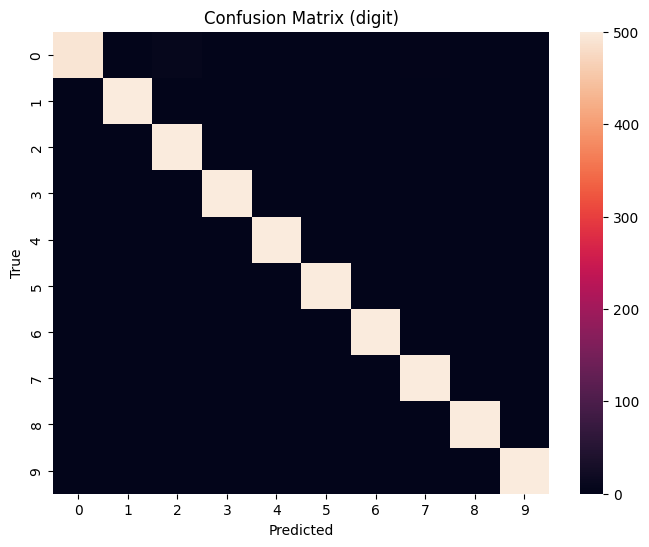

              precision    recall  f1-score   support

           0     1.0000    0.9840    0.9919       500
           1     1.0000    1.0000    1.0000       500
           2     0.9881    1.0000    0.9940       500
           3     1.0000    1.0000    1.0000       500
           4     1.0000    0.9980    0.9990       500
           5     0.9960    1.0000    0.9980       500
           6     0.9980    1.0000    0.9990       500
           7     0.9960    0.9980    0.9970       500
           8     1.0000    1.0000    1.0000       500
           9     1.0000    0.9980    0.9990       500

    accuracy                         0.9978      5000
   macro avg     0.9978    0.9978    0.9978      5000
weighted avg     0.9978    0.9978    0.9978      5000



In [16]:
# === DIGIT ========
labels = sorted(np.unique(y_true))
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix ({CFG.task})")
plt.show()

print(classification_report(y_true, y_pred, digits=4))


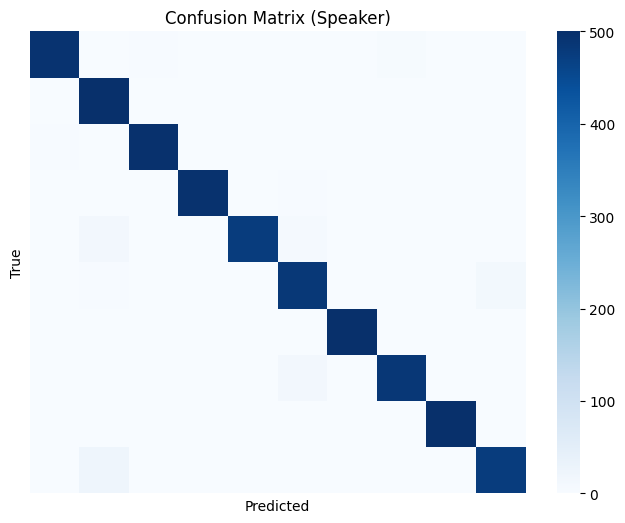

              precision    recall  f1-score   support

           0     0.9960    0.9860    0.9910       500
           1     0.9225    1.0000    0.9597       500
           2     0.9940    0.9940    0.9940       500
           3     1.0000    0.9920    0.9960       500
           4     1.0000    0.9520    0.9754       500
           5     0.9472    0.9680    0.9575       500
           6     1.0000    1.0000    1.0000       500
           7     0.9878    0.9700    0.9788       500
           8     1.0000    1.0000    1.0000       500
           9     0.9734    0.9520    0.9626       500

    accuracy                         0.9814      5000
   macro avg     0.9821    0.9814    0.9815      5000
weighted avg     0.9821    0.9814    0.9815      5000



In [23]:
# === SPEAKER ==========
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

labels = sorted(np.unique(y_true))
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, fmt="d", xticklabels=False, yticklabels=False, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Speaker)")
plt.show()

print(classification_report(y_true, y_pred, digits=4))


## 12) Inference



DIGIT sample file: 3_07_40.wav
True digit: 3
Predicted: 3  |  Confidence: 1.000


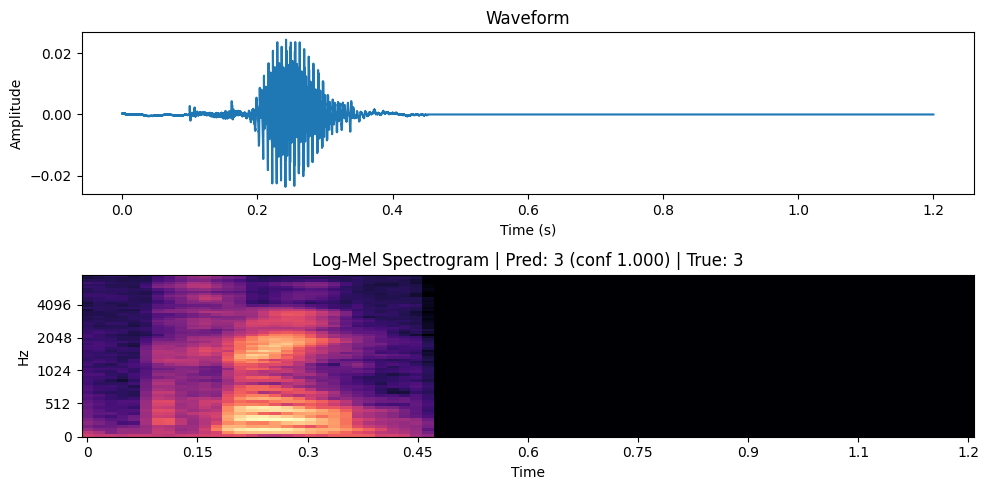

In [28]:
# --- Single-file inference (DIGIT) with waveform + spectrogram ---------------
import numpy as np, matplotlib.pyplot as plt, librosa, librosa.display
from IPython.display import Audio, display
from pathlib import Path

# 1) Pick a sample file from the dataset (fixed seed for reproducibility)
sample_row = meta.sample(1, random_state=1337).iloc[0]
sample_path = sample_row["path"]
true_digit = int(sample_row["digit"])

print("DIGIT sample file:", Path(sample_path).name)
print("True digit:", true_digit)

# 2) Predict using your saved digit checkpoint
pred_label, conf = predict_file(sample_path, task="digit")
print(f"Predicted: {pred_label}  |  Confidence: {conf:.3f}")

# 3) Load, feature, and visualize
x, sr = load_audio(sample_path, CFG.target_sr, CFG.max_duration, CFG.top_db_trim)
mel = to_logmelspec(x, sr, CFG.n_fft, CFG.hop_length, CFG.n_mels, CFG.fmin, CFG.fmax)

# Waveform
plt.figure(figsize=(10, 5))
t = np.arange(len(x)) / sr
plt.subplot(2,1,1)
plt.plot(t, x)
plt.title("Waveform")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude")

# Spectrogram
plt.subplot(2,1,2)
librosa.display.specshow(mel, sr=sr, hop_length=CFG.hop_length, x_axis="time", y_axis="mel", fmin=CFG.fmin, fmax=CFG.fmax)
plt.title(f"Log-Mel Spectrogram | Pred: {pred_label} (conf {conf:.3f}) | True: {true_digit}")
plt.tight_layout()
plt.show()

# 4) play audio
display(Audio(data=x, rate=sr))


SPEAKER sample file: 9_26_3.wav
True speaker ID: 26
Predicted speaker: 10  |  Confidence: 1.000


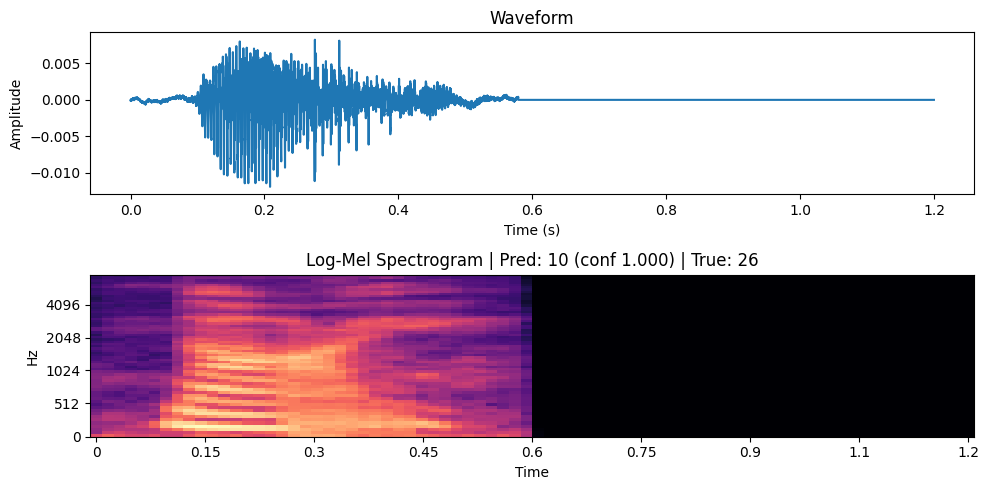

In [29]:
# --- Single-file inference (SPEAKER) with waveform + spectrogram -------------
import numpy as np, matplotlib.pyplot as plt, librosa, librosa.display
from IPython.display import Audio, display
from pathlib import Path

# 1) Pick a sample file (fixed seed for reproducibility)
sample_row = meta.sample(1, random_state=2025).iloc[0]
sample_path = sample_row["path"]
true_speaker = int(sample_row["speaker"])

print("SPEAKER sample file:", Path(sample_path).name)
print("True speaker ID:", true_speaker)

# 2) Predict using your saved speaker checkpoint
pred_label, conf = predict_file(sample_path, task="speaker")
print(f"Predicted speaker: {pred_label}  |  Confidence: {conf:.3f}")

# 3) Load, feature, and visualize
x, sr = load_audio(sample_path, CFG.target_sr, CFG.max_duration, CFG.top_db_trim)
mel = to_logmelspec(x, sr, CFG.n_fft, CFG.hop_length, CFG.n_mels, CFG.fmin, CFG.fmax)

# Waveform
plt.figure(figsize=(10, 5))
t = np.arange(len(x)) / sr
plt.subplot(2,1,1)
plt.plot(t, x)
plt.title("Waveform")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude")

# Spectrogram
plt.subplot(2,1,2)
librosa.display.specshow(mel, sr=sr, hop_length=CFG.hop_length, x_axis="time", y_axis="mel", fmin=CFG.fmin, fmax=CFG.fmax)
plt.title(f"Log-Mel Spectrogram | Pred: {pred_label} (conf {conf:.3f}) | True: {true_speaker}")
plt.tight_layout()
plt.show()

# 4) play audio
display(Audio(data=x, rate=sr))



## 13) Conclusion

In this project, I successfully explored two complementary audio classification tasks using the **AudioMNIST** dataset - recognizing *what digit* is spoken and *who* is speaking.  
Through systematic preprocessing, feature extraction via **log-mel spectrograms**, and deep learning architectures suited to each task, I achieved strong and interpretable results.  

For **digit classification**, the **CNNStrong** model effectively captured localized frequency-time patterns, reaching nearly **99.7% accuracy**, demonstrating the strength of convolutional layers for phonetic recognition.  
For **speaker identification**, the **CRNN-XL** model combined **CNN** and **Bi-LSTM** layers to learn both spatial and temporal dependencies, achieving around **98.1% accuracy**, showing its ability to model speaker-specific vocal traits.  

Overall, these experiments illustrate how tailoring neural architectures to the nature of the audio problem  **static pattern recognition** for digits vs. **temporal dynamic modeling** for speakers leads to state-of-the-art performance and deep insight into speech representation learning.
